<a href="https://colab.research.google.com/github/HyelinNAM/TIL/blob/master/GAN/0401_DCGAN(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generate Fashion MNIST using DCGAN (28x28)

In [0]:
import time
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
# set hyperparameters
batch_size = 64 # batch size
z_dim = 10 # length of vector z
nc = 1 # the number of channel (image; color-3, gray scale-1)
g_ch = 64 # the number of featuremap (generator)
d_ch = 64 # the number of featuremap (discriminator)
lr = 0.0002 # learning rate

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()

    self.conv1 = nn.ConvTranspose2d(
        in_channels = z_dim,
        out_channels = g_ch * 8,
        kernel_size = 4,
        stride = 1,
        padding=0
    ) # batch_size * (g_ch*8) * 4 * 4
    self.conv1_bn = nn.BatchNorm2d(g_ch*8) 
    self.conv2 = nn.ConvTranspose2d(g_ch*8,g_ch*4,4,2,1)
    self.conv2_bn = nn.BatchNorm2d(g_ch*4)
    self.conv3 = nn.ConvTranspose2d(g_ch*4,g_ch*2,4,2,1)
    self.conv3_bn = nn.BatchNorm2d(g_ch*2)
    self.conv4 = nn.ConvTranspose2d(g_ch*2,g_ch,4,2,1)
    self.conv4_bn = nn.BatchNorm2d(g_ch)
    self.conv5 = nn.ConvTranspose2d(g_ch,nc,4,2,1)

  def weight_init(self,mean,std):
    for m in self._modules:
      nn.init.normal_(self._modules[m].weight.data,mean,std)

  def forward(self,input):
    x = F.relu(self.conv1_bn(self.conv1(input)))
    x = F.relu(self.conv2_bn(self.conv2(x)))
    x = F.relu(self.conv3_bn(self.conv3(x)))
    x = F.relu(self.conv4_bn(self.conv4(x)))
    x = torch.tanh(self.conv5(x))

    return x

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    
    self.conv1 = nn.Conv2d(
        in_channels=nc,
        out_channels=d_ch,
        kernel_size=4,
        stride=2,
        padding=1
    )
    self.conv2 = nn.Conv2d(d_ch,d_ch*2,4,2,1)
    self.conv2_bn = nn.BatchNorm2d(d_ch*2)
    self.conv3 = nn.Conv2d(d_ch*2,d_ch*4,4,2,1)
    self.conv3_bn = nn.BatchNorm2d(d_ch*4)
    self.conv4= nn.Conv2d(d_ch*4,d_ch*8,4,2,1)
    self.conv4_bn = nn.BatchNorm2d(d_ch*8)
    self.conv5 = nn.Conv2d(d_ch*8,1,4,1,0)

  def weight_init(self,mean,std):
    for m in self._modules:
      nn.init.normal_(self._modules[m].weight.data,mean,std)

  def forward(self,input):
    x = F.leaky_relu(self.conv1(input),0.2)
    x = F.leaky_relu(self.conv2_bn(self.conv2(x)),0.2)
    x = F.leaky_relu(self.conv3_bn(self.conv3(x)),0.2)
    x = F.leaky_relu(self.conv4_bn(self.conv4(x)),0.2)
    x = torch.sigmoid(self.conv5(x))

    return x

In [0]:
G = Generator()
D = Discriminator()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [0]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(0.5,0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(0.5,0.999))

In [0]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), # 이미지를 텐서로/데이터를 0~1 범위로
    transforms.Normalize((0.5,),(0.5,)),
    # 이 때 0.5 값을 빼고, 나눠주는 것 (평균을 0.5로 만드는 것 X) > -1~1 픽셀값 갖게됨
    # + GAN에서 Normalize하는 이유) (1) improve convergence of th nets / (2) giving an equal range of value to all features
])

# Download and load the training data
train = datasets.FashionMNIST(root='data',download=True,train=True,transform=transform)

trainloader = torch.utils.data.DataLoader(
    train,
    batch_size=64,
    shuffle=True
)

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!





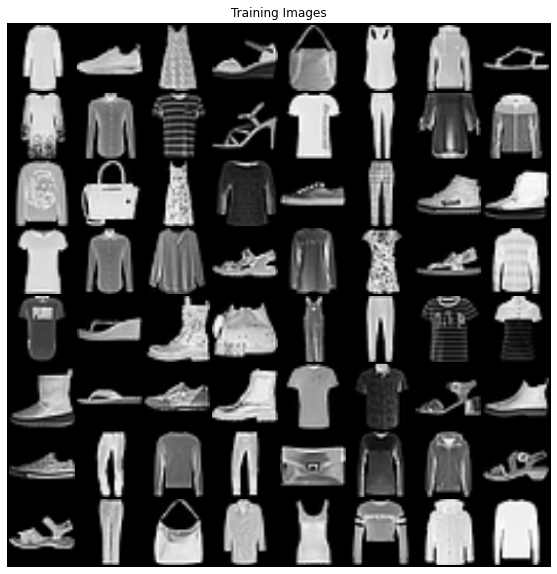

In [0]:
import torchvision.utils as vutils

real_batch = next(iter(trainloader)) # len(iter(trainloader)) = 938 / type(real_batch) > list /len(real_batch)=2 > data, label
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
# real_batch[0].shape > [64,1,64,64]

In [0]:
def img_show(data,epoch):
  f = plt.figure(figsize=(10,10))
  plt.axis("off")
  plt.title(f'{epoch} - image')
  plt.imshow(np.transpose(vutils.make_grid(data.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0))) # 64,1,64,64

  f.savefig(f'{epoch}')

Start Training Loop...
[1/20][50/938]	Loss_D:0.105	Loss_G: 2.937 	Prob_R:  0.953 	Prob_F1:  0.055 	Prob_F2:  0.053
[1/20][100/938]	Loss_D:0.031	Loss_G: 4.141 	Prob_R:  0.987 	Prob_F1:  0.017 	Prob_F2:  0.016
[1/20][150/938]	Loss_D:0.013	Loss_G: 4.925 	Prob_R:  0.994 	Prob_F1:  0.008 	Prob_F2:  0.007
[1/20][200/938]	Loss_D:1.264	Loss_G: 0.780 	Prob_R:  0.568 	Prob_F1:  0.497 	Prob_F2:  0.461
[1/20][250/938]	Loss_D:0.062	Loss_G: 3.800 	Prob_R:  0.965 	Prob_F1:  0.026 	Prob_F2:  0.026
[1/20][300/938]	Loss_D:0.820	Loss_G: 1.329 	Prob_R:  0.694 	Prob_F1:  0.357 	Prob_F2:  0.267
[1/20][350/938]	Loss_D:1.079	Loss_G: 1.285 	Prob_R:  0.560 	Prob_F1:  0.377 	Prob_F2:  0.286
[1/20][400/938]	Loss_D:1.122	Loss_G: 2.259 	Prob_R:  0.809 	Prob_F1:  0.591 	Prob_F2:  0.106
[1/20][450/938]	Loss_D:1.156	Loss_G: 0.966 	Prob_R:  0.564 	Prob_F1:  0.432 	Prob_F2:  0.386
[1/20][500/938]	Loss_D:1.245	Loss_G: 0.881 	Prob_R:  0.493 	Prob_F1:  0.405 	Prob_F2:  0.420
[1/20][550/938]	Loss_D:1.248	Loss_G: 1.059 	Prob

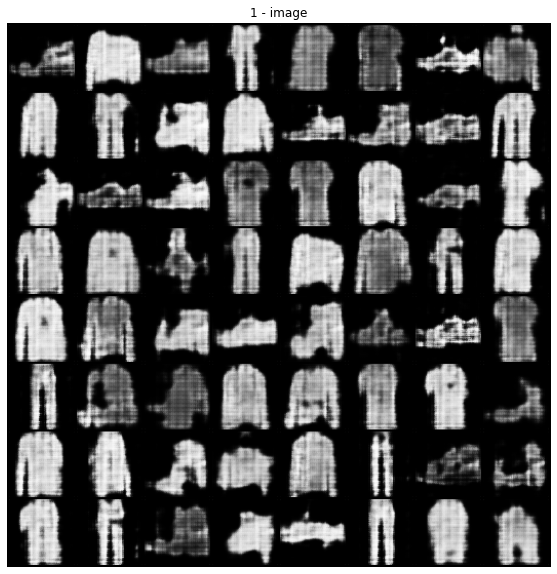

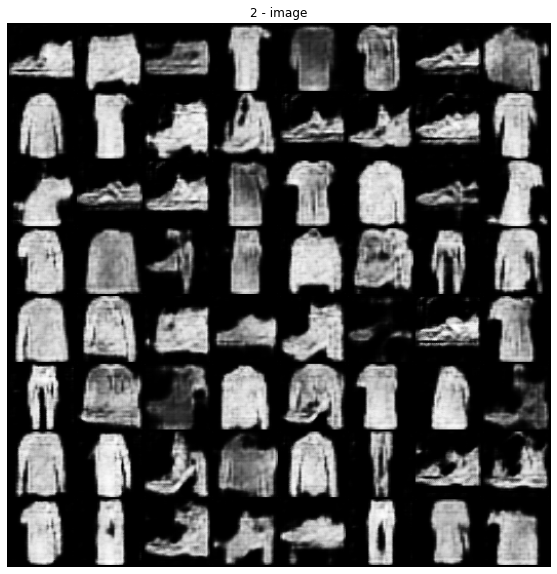

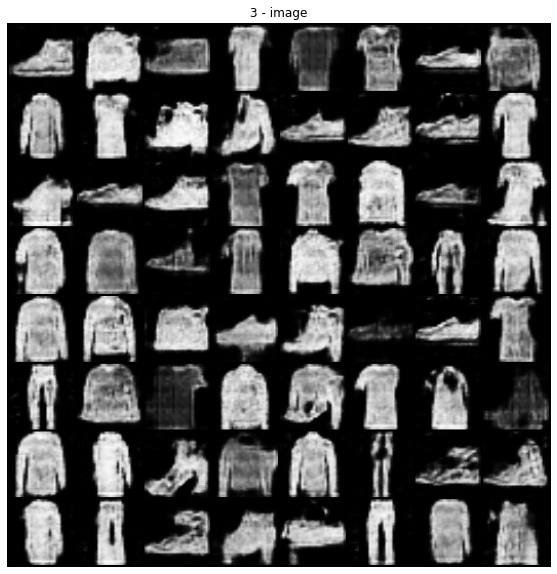

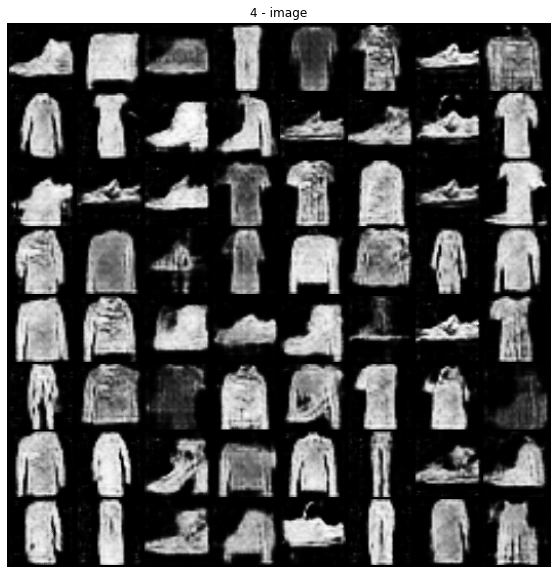

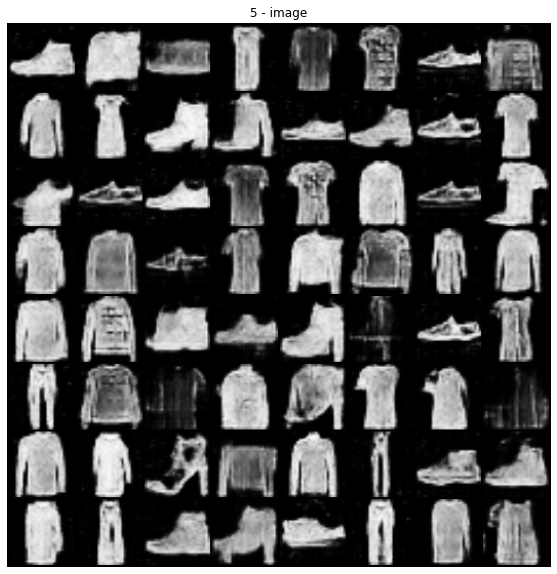

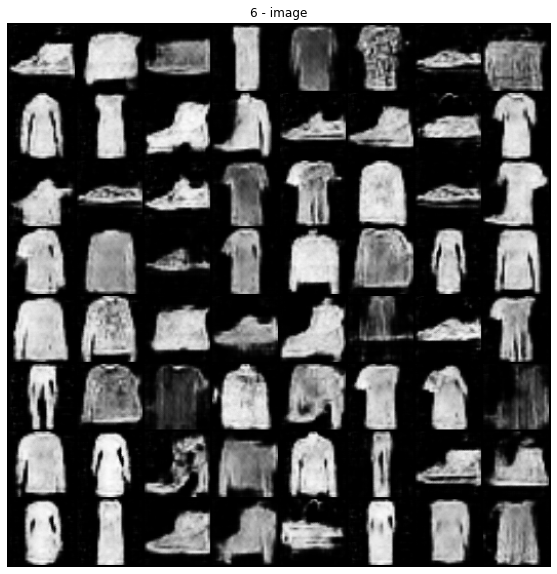

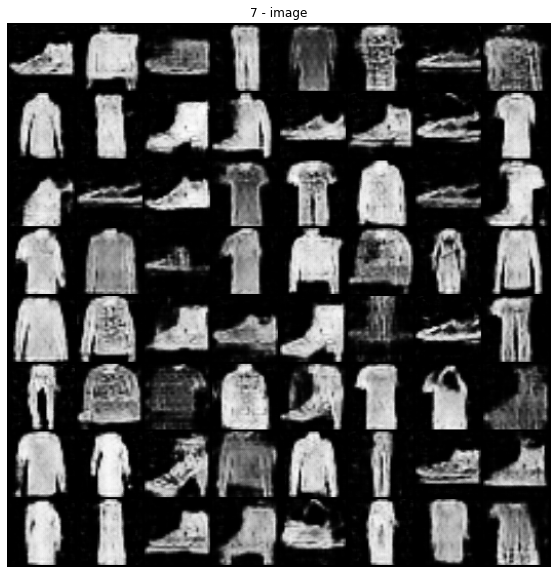

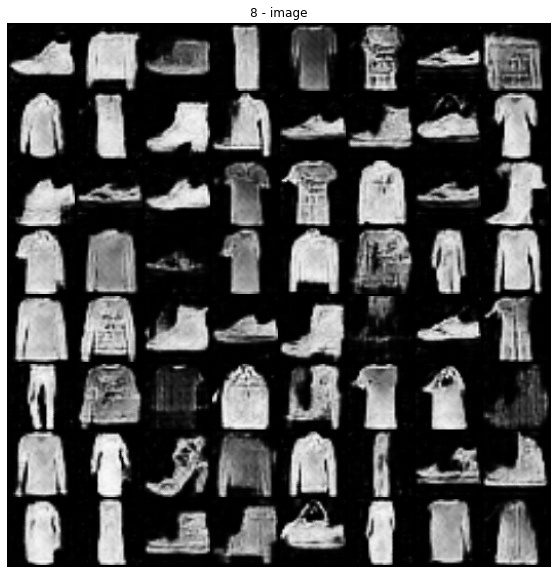

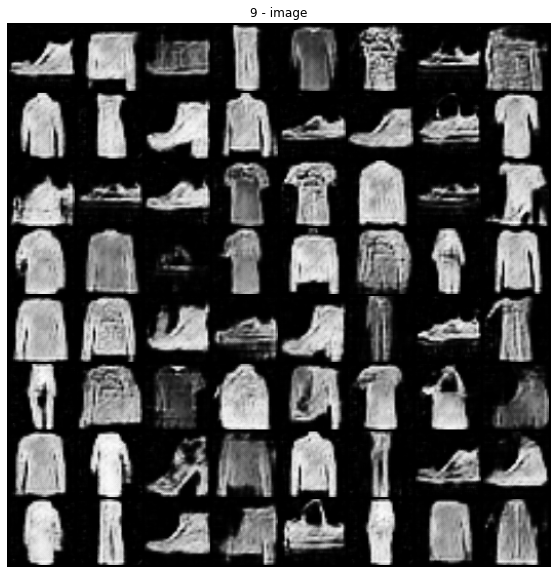

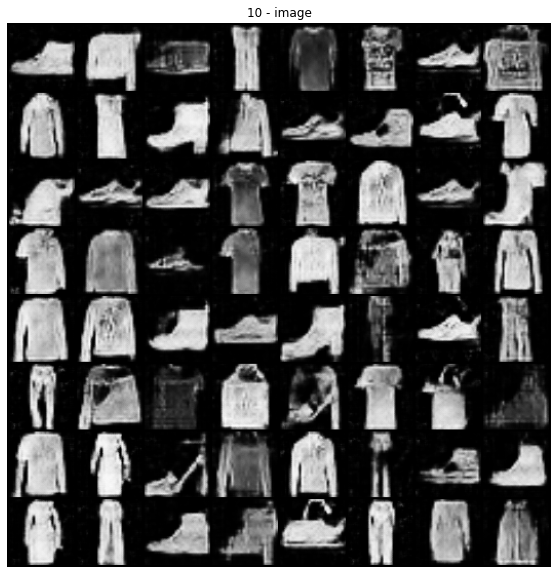

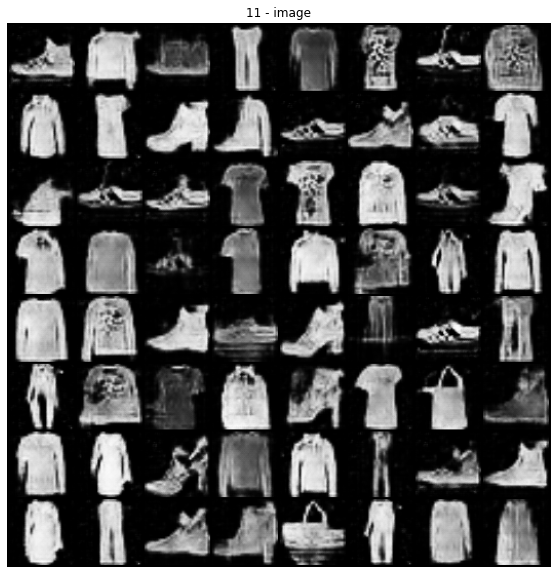

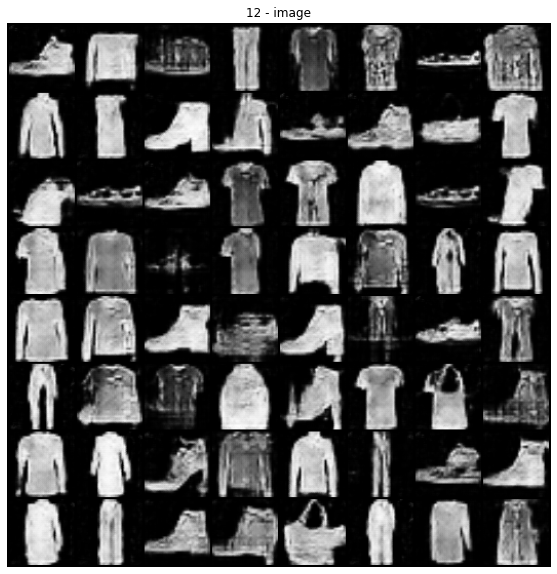

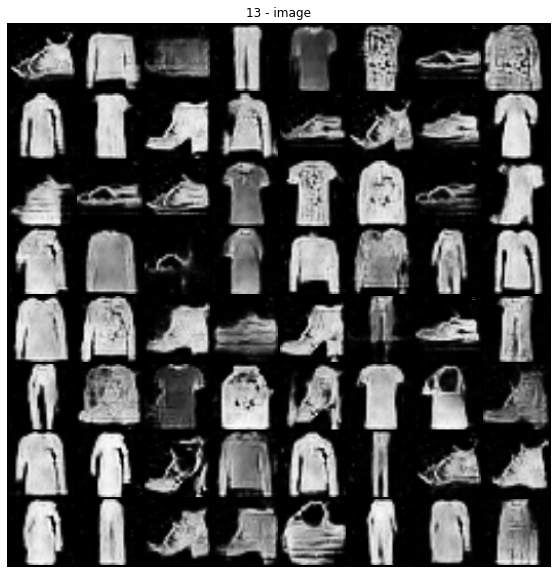

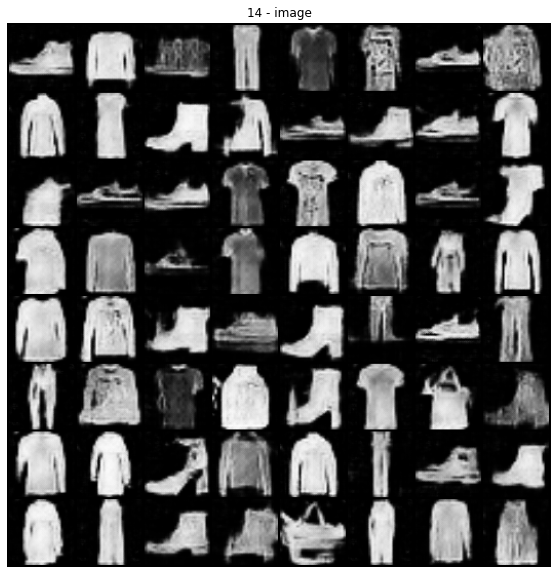

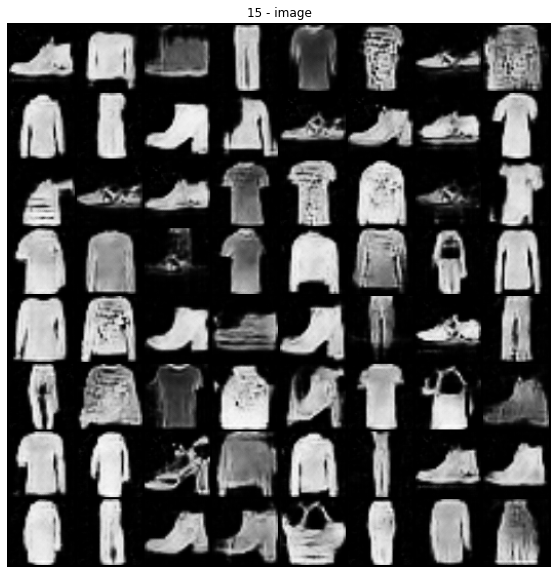

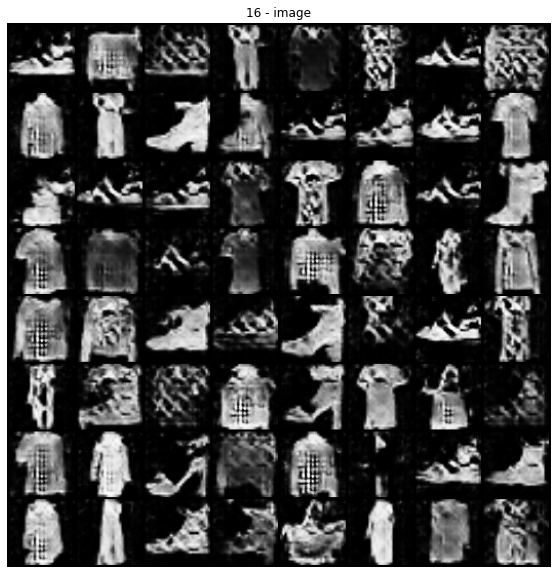

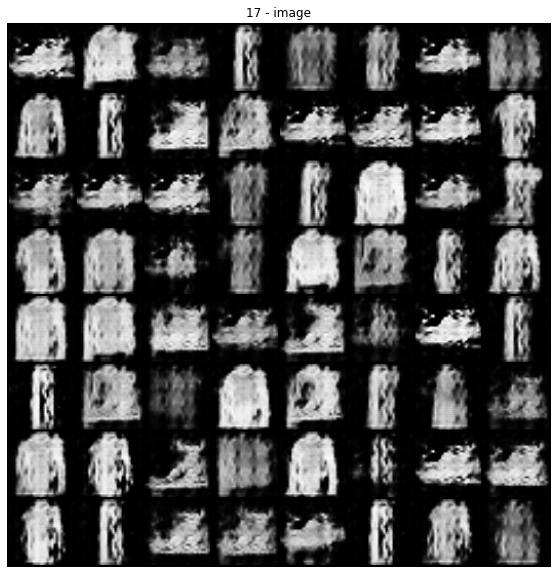

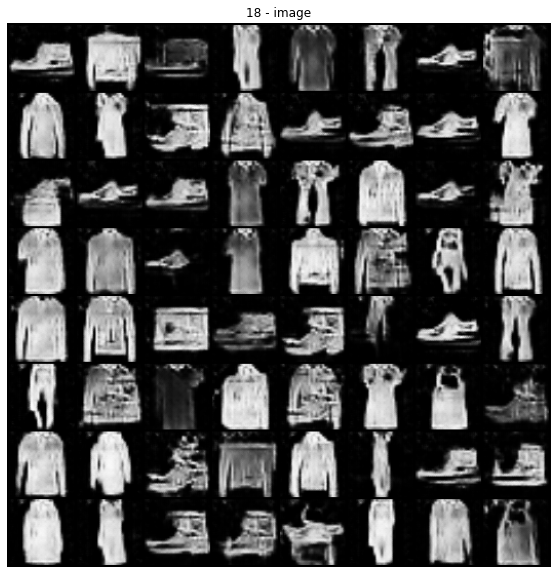

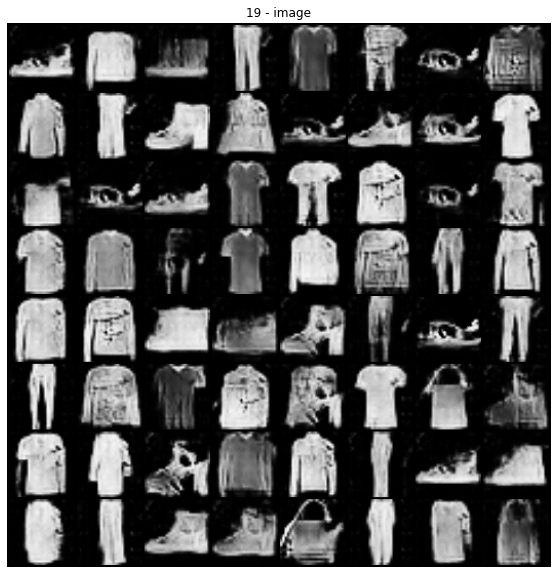

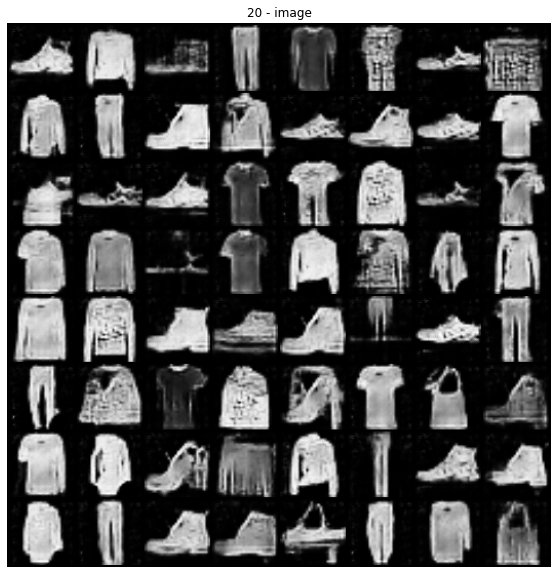

In [0]:
epochs = 20

train_hist={}
img_hist = {}

train_hist['D_losses'] = []
train_hist['G_losses'] = []

#img_hist = {'current_epoch':img}

print('Start Training Loop...')

start_time = time.time()

fixed_noise = torch.randn((batch_size,z_dim),device=device).view(-1,z_dim,1,1)

for epoch in range(epochs):

  iter_ = 1

  D_losses = []
  G_losses = []

  epoch_start_time = time.time()

  for img, label in trainloader: #len(trainloader) = 938
    # img.shape > [64,1,64,64]
    # label.shape > [64]

    ### 1.Update D ###

    D.zero_grad()
    
    img = img.to(device)
    batch_size = img.size()[0]
    r_label = torch.ones(batch_size).to(device)
    f_label = torch.zeros(batch_size).to(device)

    ### 1-1.using Real image ###
    D_result = D(img).squeeze() # [64,1,1,1] > [64]
    # = D(img).view(-1)
    D_real = criterion(D_result,r_label)
    D_real.backward()
    Prob_R = D_result.mean().item()

    ### 1-2.using Fake image ###
    noise = torch.randn((batch_size,z_dim),device=device).view(-1,z_dim,1,1) # (64,100) > (64,100,1,1)
    fake = G(noise)
    D_result = D(fake.detach()).squeeze()

    Prob_F1 = D_result.mean().item()
    
    D_fake = criterion(D_result,f_label)
    D_fake.backward()

    D_train_loss = D_real + D_fake

    optimizerD.step()
    
    train_hist['D_losses'].append(D_train_loss.data)

    ### 2.Update G ###

    G.zero_grad()

    D_result = D(fake).squeeze() # [64,1,1,1] > [64]

    G_train_loss = criterion(D_result,r_label)
    G_train_loss.backward()

    Prob_F2 = D_result.mean().item()
    
    optimizerG.step()
    
    train_hist['G_losses'].append(G_train_loss.data)

    if iter_ % 50 == 0:
      print(f'[{epoch+1}/{epochs}][{iter_}/{len(trainloader)}]\tLoss_D:{D_train_loss.data:.3f}\tLoss_G: {G_train_loss.data:.3f} \tProb_R: {Prob_R: .3f} \tProb_F1: {Prob_F1: .3f} \tProb_F2: {Prob_F2: .3f}')

    iter_+=1

  epoch_end_time = time.time()
  per_epoch_ptime = epoch_end_time - epoch_start_time

  fixed_img = G(fixed_noise)
  img_hist[epoch] = fixed_img.detach()
  img_show(fixed_img.detach().cpu(),epoch+1)
  
  print(f'[{epoch+1}/{epochs}] -ptime: {per_epoch_ptime:.2f} ')

print('finished')

In [0]:
torch.save({
    'G_state_dict':G.state_dict(),
    'D_state_dict':D.state_dict(),
    'OpG_state_dict':optimizerG.state_dict(),
    'OpD_state_dict':optimizerD.state_dict(),
    },'/content/drive/My Drive/model')